# Imports

In [32]:
import torch
import torchvision
import torchvision.transforms as transforms
import pandas as pd
import torch.optim as optim
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import operator
from datetime import datetime

In [33]:
def split_data(stock, lookback):
    data_raw = stock.to_numpy()
    data = []

    for index in range(len(data_raw) - lookback):
        data.append(data_raw[index: index + lookback])

    data = np.array(data)
    test_set_size = int(np.round(0.05*data.shape[0]))
    train_set_size = data.shape[0] - (test_set_size)

    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]

    x_test = data[train_set_size:,:-1]
    y_test = data[train_set_size:,-1,:]

    return [x_train, y_train, x_test, y_test]

def string_to_time(date):

    date = datetime.strptime(date, '%Y-%m-%d')
    date = datetime.timestamp(date)
    return date

def normalize(x, min, max):
    return (x - min)/(max - min)

def reverse_normalize(y, min, max):
    return y*(max - min) + min

def min_max_dic(dataset):
    dic = {}
    for col in dataset.columns:
        dic[col] = [dataset[col].min(), dataset[col].max()]
        dataset[col] = dataset[col].apply(lambda x: normalize(x, dic[col][0], dic[col][1]))
    return dic

In [34]:
import torch.nn as nn

class GRU(nn.Module):
    def __init__(self, input_size, hidden_dim, num_layers, output_dim):
        super(GRU, self).__init__()

        self.gru = nn.GRU(input_size, hidden_dim, num_layers)

        self.linear = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        output, _ = self.gru(x)

        output = output[:, -1, :]

        output = self.linear(output)
        return output

# Define CUDA

In [35]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [36]:
print(device)

cuda


# Load Dataset

In [37]:
data = pd.read_csv('apple.csv')

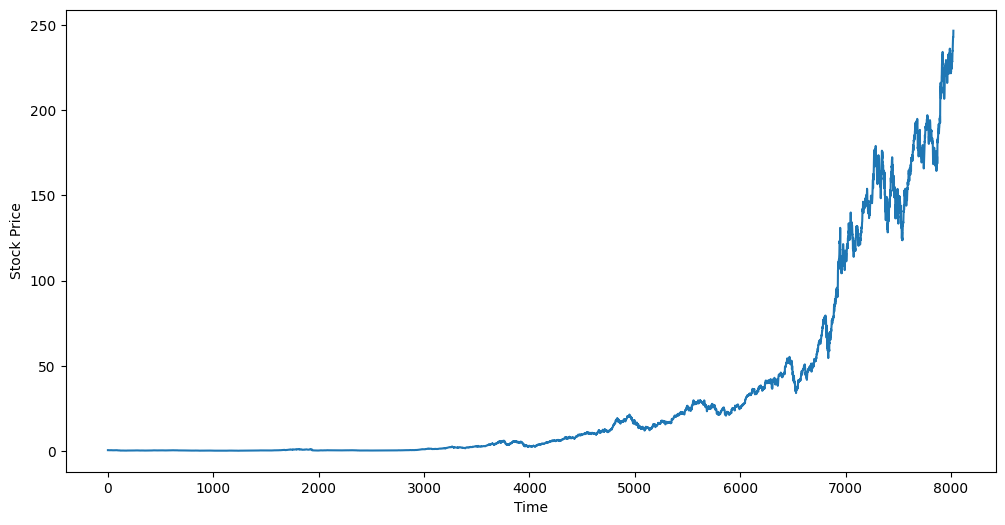

In [38]:
#Close is stock price at the end of that day
plt.figure(figsize=(12, 6))
plt.plot(list(range(len(data))), data['Close'])
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.show()

# Proprocess Dataset

In [39]:
from datetime import datetime

def string_to_time(date):
    date = datetime.strptime(date, '%Y-%m-%d %H:%M:%S%z')
    date = datetime.timestamp(date)
    return date

In [40]:
data = data.drop(['7rsi_APPLE', '14rsi_APPLE', '21rsi_APPLE'], axis=1)

In [41]:
#normalize dataset and keep track of close value
data['Date'] = data['Date'].apply(lambda x: string_to_time(x))
min_max_dictionary = min_max_dic(data)
display(data)

stock_value = data[['Close']]

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,pct_change_APPLE,log_change_APPLE,...,fft_imag_APPLE,fft_magnitude_APPLE,fft_phase_APPLE,IBM_close,INTC_close,MSFT_close,QCOM_close,SPY_close,TXN_close,target
0,0.000000,0.001394,0.001394,0.001371,0.001355,0.032720,0.0,0.0,0.602169,0.712049,...,0.999299,0.000812,0.856939,0.004656,0.005561,0.000642,0.000000,0.000510,0.000447,0.001400
1,0.000258,0.001365,0.001394,0.001379,0.001406,0.029267,0.0,0.0,0.644091,0.746690,...,0.999291,0.000831,0.862069,0.005215,0.006859,0.000683,0.000065,0.000810,0.000852,0.001371
2,0.000344,0.001409,0.001401,0.001409,0.001377,0.021397,0.0,0.0,0.590342,0.702051,...,0.999258,0.000808,0.864019,0.004966,0.006859,0.000745,0.000140,0.000900,0.000745,0.001364
3,0.000430,0.001417,0.001387,0.001357,0.001369,0.032462,0.0,0.0,0.604652,0.714135,...,0.999292,0.000837,0.862935,0.004469,0.006174,0.000719,0.000259,0.001350,0.000703,0.001349
4,0.000516,0.001387,0.001365,0.001371,0.001355,0.024887,0.0,0.0,0.599737,0.710001,...,0.999272,0.000865,0.871412,0.004866,0.006282,0.000580,0.000475,0.001530,0.000703,0.001283
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8018,0.999484,0.982861,0.981873,0.986655,0.983377,0.002002,0.0,0.0,0.624537,0.730684,...,0.442489,0.422035,0.246779,0.961228,0.345836,0.925528,0.718913,0.993316,0.894404,0.980781
8019,0.999570,0.995408,0.987335,0.996364,0.984837,0.002749,0.0,0.0,0.611272,0.719675,...,0.282836,0.548669,0.272424,0.980485,0.337414,0.938921,0.722286,0.999743,0.891748,0.980902
8020,0.999656,1.000000,0.989075,1.000000,0.984959,0.002161,0.0,0.0,0.609673,0.718340,...,0.153902,0.679045,0.303389,0.985889,0.318258,0.950118,0.712918,0.998029,0.874988,0.980095
8021,0.999742,0.995572,0.989439,0.999793,0.984148,0.001733,0.0,0.0,0.608561,0.717411,...,0.084473,0.803998,0.334245,1.000000,0.320239,0.952163,0.708993,1.000000,0.875492,0.995882


In [42]:
#split data into training and testing components
X_train, y_train, X_test, y_test = split_data(stock_value, 20)

X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float()
X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float()

# Initialize Hyperparameters

In [43]:
input_size = 1
hidden_dim = 64
num_layers = 3
output_dim = 1
epochs = 400

# Define Model (GRU)

In [44]:
model = GRU(input_size, hidden_dim, num_layers, output_dim).to(device)
loss_func = nn.MSELoss(reduction='mean').to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train Model

In [45]:
train_loss = []  # Track RMSE during training
min_loss = np.Inf  # Initialize the minimum RMSE

for epoch in range(epochs):
    # Zero out gradients
    optimizer.zero_grad()

    # Forward pass
    pred = model(X_train.to(device))
    loss = loss_func(pred, y_train.to(device))

    # Calculate RMSE
    rmse = torch.sqrt(loss).item()
    train_loss.append(rmse)

    print('Epoch {},    RMSE: {:.10f}\n'.format(epoch, rmse))

    # Keep track of lowest RMSE and save as best model
    if rmse < min_loss:
        print('     New Minimum RMSE: {:.10f} ----> {:.10f}\n'.format(min_loss, rmse))
        min_loss = rmse
        torch.save(model.state_dict(), 'best_model.pt')

    # Backpropagate
    loss.backward()
    optimizer.step()


Epoch 0,    RMSE: 0.1677495390

     New Minimum RMSE: inf ----> 0.1677495390

Epoch 1,    RMSE: 0.1699969471

Epoch 2,    RMSE: 0.1624590009

     New Minimum RMSE: 0.1677495390 ----> 0.1624590009

Epoch 3,    RMSE: 0.1624583900

     New Minimum RMSE: 0.1624590009 ----> 0.1624583900

Epoch 4,    RMSE: 0.1602029353

     New Minimum RMSE: 0.1624583900 ----> 0.1602029353

Epoch 5,    RMSE: 0.1549765021

     New Minimum RMSE: 0.1602029353 ----> 0.1549765021

Epoch 6,    RMSE: 0.1514639854

     New Minimum RMSE: 0.1549765021 ----> 0.1514639854

Epoch 7,    RMSE: 0.1493038088

     New Minimum RMSE: 0.1514639854 ----> 0.1493038088

Epoch 8,    RMSE: 0.1447526515

     New Minimum RMSE: 0.1493038088 ----> 0.1447526515

Epoch 9,    RMSE: 0.1379480511

     New Minimum RMSE: 0.1447526515 ----> 0.1379480511

Epoch 10,    RMSE: 0.1315387487

     New Minimum RMSE: 0.1379480511 ----> 0.1315387487

Epoch 11,    RMSE: 0.1252267808

     New Minimum RMSE: 0.1315387487 ----> 0.1252267808

Epoch 1

# Evaluating Model

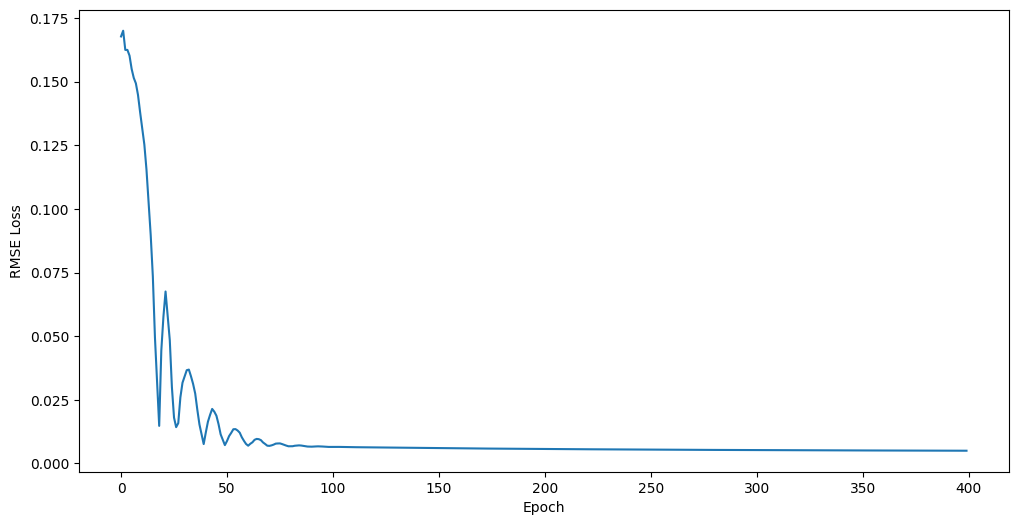

In [58]:
#visualize loss throughout training
plt.figure(figsize=(12, 6))
plt.xlabel('Epoch')
plt.ylabel('RMSE Loss')
plt.plot(list(range(epochs)), train_loss)

# Load the Best Model

In [48]:
best_model = GRU(input_size, hidden_dim, num_layers, output_dim).to(device)
best_model.load_state_dict(torch.load('best_model.pt'))

<ipython-input-48-f1085af7dbfa>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load('best_model.pt'))


<All keys matched successfully>

In [49]:
#get predictions
gru_predictions = model(X_test.to(device))
test_loss = loss_func(gru_predictions, y_test.to(device))
gru_predictions = gru_predictions.squeeze().tolist()

# Reverse Normalize

In [50]:
min = min_max_dictionary['Close'][0]
max = min_max_dictionary['Close'][1]

#reverse normalize predictions and dataset values
gru_predictions = [reverse_normalize(x, min, max) for x in np.array(gru_predictions)]

stock_value = [reverse_normalize(x, min, max) for x in np.array(stock_value)]

# Visualizing and Testing Model

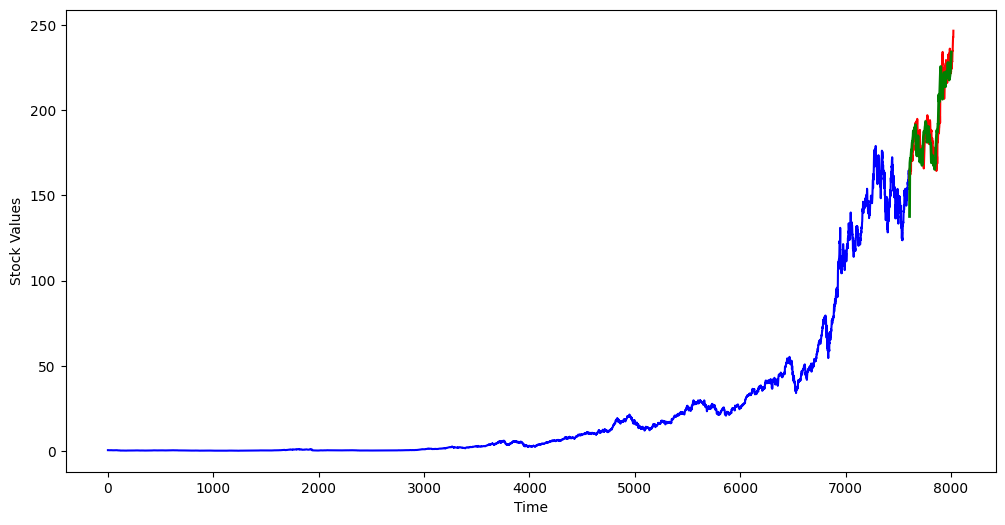

In [51]:
plt.figure(figsize=(12, 6))
plt.plot([i for i in range(X_train.size(0))], stock_value[:X_train.size(0)], color='b', label='trained values')

#plot test range and predictions by the GRU
time_values_actual = list(range(X_train.size(0), len(stock_value)))
time_values_pred = list(range(X_train.size(0), X_train.size(0) + y_test.size(0)))
plt.xlabel('Time')
plt.ylabel('Stock Values')
plt.plot(time_values_actual, stock_value[-len(time_values_actual):], color='r', label='actual values')
plt.plot(time_values_pred[3:], gru_predictions[3:], color='g', linewidth=2, label='predicted values')

plt.show()

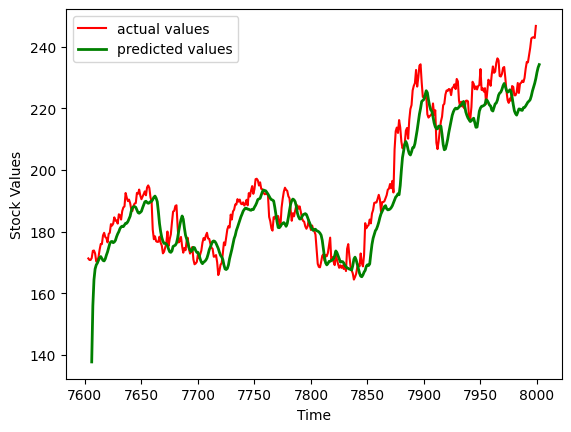

In [52]:
#closer plot test range and predictions by the GRU
time_values_actual = list(range(X_train.size(0), X_train.size(0) + y_test.size(0) - 3 ))
time_values_pred = list(range(X_train.size(0), X_train.size(0) + y_test.size(0)))
plt.xlabel('Time')
plt.ylabel('Stock Values')
plt.plot(time_values_actual, stock_value[-len(time_values_actual):], color='r', label='actual values')
plt.plot(time_values_pred[3:], gru_predictions[3:], color='g', linewidth=2, label='predicted values')
plt.legend()

plt.show()

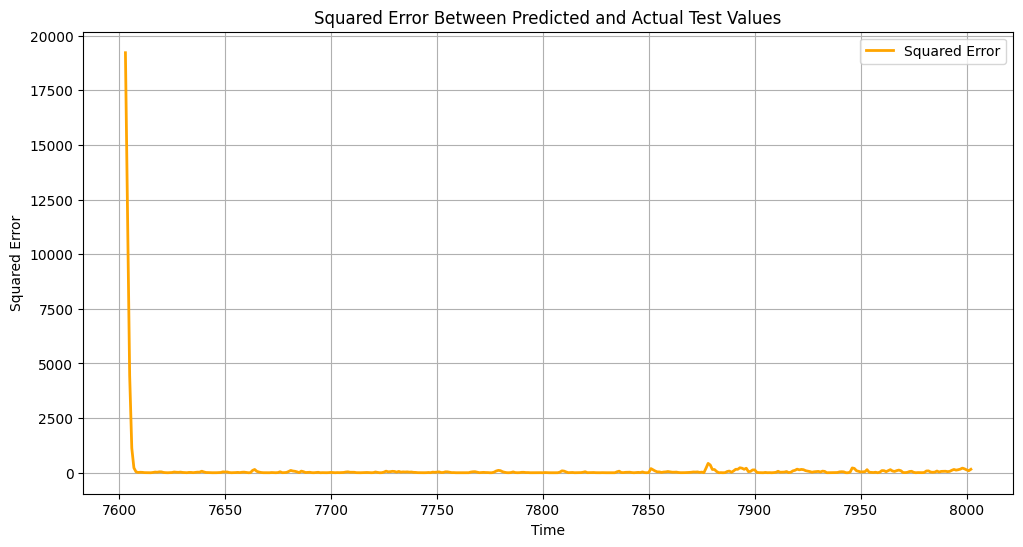

In [53]:
# Plot the squared error for the test set
# Compute the squared errors between predictions and actual values
squared_errors = [(pred - actual) ** 2 for pred, actual in zip(gru_predictions, stock_value[-len(gru_predictions):])]

plt.figure(figsize=(12, 6))

time_values_pred = list(range(X_train.size(0), X_train.size(0) + len(squared_errors)))
plt.plot(time_values_pred, squared_errors, color='orange', label='Squared Error', linewidth=2)

plt.xlabel('Time')
plt.ylabel('Squared Error')
plt.title('Squared Error Between Predicted and Actual Test Values')
plt.legend()
plt.grid(True)
plt.show()


In [64]:
mse = np.mean(squared_errors)
rmse = np.sqrt(mse)

print(f"Root mean Squared Error (RMSE): {rmse}")

Root mean Squared Error (RMSE): 11.312965639320456


In [63]:
baseline_mse = np.mean((stock_value[-len(gru_predictions):] - np.mean(stock_value[-len(gru_predictions):])) ** 2)
baseline_rmse = np.sqrt(baseline_mse)
print(f"Baseline RMSE: {baseline_rmse}")

Baseline RMSE: 21.872761744170738
